In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from pylab import rcParams
from sklearn.preprocessing import scale 

%matplotlib inline
plt.style.use('seaborn-white')

In [33]:
import json
with open("first_data_940.json", 'r', encoding='UTF-8') as f:
    data = json.load(f)

In [34]:
NEW_COL = ['name', 'code', 'time', 'price', 'time_1', 'price_1', 'price_dif_1',
       'sell_1', 'buy_1', 'volume_1', 'variation_1', 'post_num_1',
       'unique_id_1', 'click_1', 'like_1', 'dislike_1', 'time_2', 'price_2',
       'price_dif_2', 'sell_2', 'buy_2', 'volume_2', 'variation_2',
       'post_num_2', 'unique_id_2', 'click_2', 'like_2', 'dislike_2', 'time_3',
       'price_3', 'price_dif_3', 'sell_3', 'buy_3', 'volume_3', 'variation_3',
       'post_num_3', 'unique_id_3', 'click_3', 'like_3', 'dislike_3',
       'mkt_cap', 'kospi', 'kosdaq', 'trash', 'yesterday_closing_price',
       'is_maximum', 'is_minimum', 'price_volatility', 'price_trend',
       'average_price_volatility', 'sell_minus_buy_1', 'sell_minus_buy_2',
       'sell_minus_buy_3', 'is_price_gap_stable', 'price_gap_volatility',
       'is_like_higher', 'volume_trend', 'post_num_trend', 'unique_id_trend',
       'click_trend', 'price_increase', 'did_price_increase']
'''
OLD_COL = ['name', 'code', 'time', 'price', 'time_1', 'price_1', 'price_dif_1',
       'sell_1', 'buy_1', 'volume_1', 'variation_1', 'post_num_1',
       'unique_id_1', 'click_1', 'like_1', 'dislike_1', 'time_2', 'price_2',
       'price_dif_2', 'sell_2', 'buy_2', 'volume_2', 'variation_2',
       'post_num_2', 'unique_id_2', 'click_2', 'like_2', 'dislike_2', 'time_3',
       'price_3', 'price_dif_3', 'sell_3', 'buy_3', 'volume_3', 'variation_3',
       'post_num_3', 'unique_id_3', 'click_3', 'like_3', 'dislike_3',]
'''


df = pd.DataFrame(data, columns = NEW_COL)
df = df.dropna(axis=0, how='any')

In [35]:
time_list = ["2018-02-14", "2018-02-20", "2018-02-21", "2018-02-22", "2018-02-23"]
time_filter = (df['time'].str.startswith("2018-02-14")) | \
              (df['time'].str.startswith("2018-02-20")) | \
              (df['time'].str.startswith("2018-02-23")) 
train_df = df[time_filter].reset_index(drop = True)
test_df = df[~time_filter].reset_index(drop = True)

In [36]:
COL_DROP = ['name', 'code', 'time', 'time_1', 'time_2', 'time_3', 'price_increase', \
            'did_price_increase', 'price']
X = df.drop(COL_DROP, axis = 1)
y_1 = df['price_increase']
y_2 = df['did_price_increase']
X_train = train_df.drop(COL_DROP, axis = 1)
X_test = test_df.drop(COL_DROP, axis = 1)
y_train_1 = train_df['price_increase']
y_train_2 = train_df['did_price_increase']
y_test_1 = test_df['price_increase']
y_test_2 = test_df['did_price_increase']

In [37]:
len(X_train.columns)

53

Principal component info

In [38]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X)) #standardize x

In [39]:
# Variance explained by each principal component
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([  31.39,   57.74,   62.82,   67.07,   70.69,   74.16,   77.46,
         80.2 ,   82.54,   84.56,   86.54,   88.45,   90.18,   91.83,
         93.2 ,   94.51,   95.69,   96.55,   97.19,   97.8 ,   98.29,
         98.76,   99.18,   99.48,   99.71,   99.93,   99.97,   99.99,
        100.01,  100.02,  100.02,  100.02,  100.02,  100.02,  100.02,
        100.02,  100.02,  100.02,  100.02,  100.02,  100.02,  100.02,
        100.02,  100.02,  100.02,  100.02,  100.02,  100.02,  100.02,
        100.02,  100.02,  100.02,  100.02])

In [40]:
y_1.ravel()

array([-0.94451004,  0.42492918,  0.48134777, ...,  0.47619048,
       -1.07015458,  0.2247191 ])

In [41]:
y_2.ravel()

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

principal component on y_1

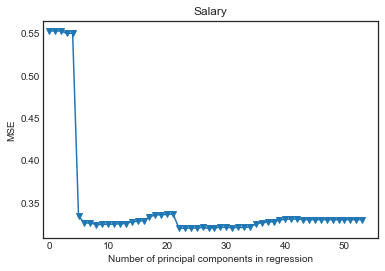

In [42]:
pca2 = PCA()
X_reduced_train = pca2.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)

mse = []

regr = LinearRegression()

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train_1, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 22 principle components, adding one component at the time.
for i in np.arange(1, 54):
    score = -1*cross_val_score(regr, X_reduced_train[:,:i], y_train_1, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1); #13 components are enough

In [43]:
mse.index(min(mse))

27

In [44]:
X_reduced_test = pca2.transform(scale(X_test))[:,:28]

# Train regression model on training data 
regr = LinearRegression()
model = regr.fit(X_reduced_train[:,:28], y_train_1)

# Prediction with test data
y_pred_1 = regr.predict(X_reduced_test)
mean_squared_error(y_test_1, y_pred_1)

0.26897932330097019

In [45]:
y_pred_df = pd.DataFrame(y_pred_1).reset_index()
compare_1 = pd.concat([pd.DataFrame(y_pred_1), y_test_1.reset_index(drop = True)], axis = 1)
compare_1.columns = ["pred_1", "test_1"]
for index, row in compare_1.iterrows():
    if row["pred_1"] == 0:
        if row["test_1"] == 0:
            value = 1
        else:
            value = 0
    else:
        sign = row["pred_1"] * row["test_1"]
        if row["test_1"] == 0:
            value = 0
        elif sign > 0:
            value = 1 
        else:
            value = 0
    compare_1.set_value(index, "sign", value)

In [46]:
compare_1['sign'].value_counts()

1.0    893
0.0    487
Name: sign, dtype: int64

principal component  on y_2

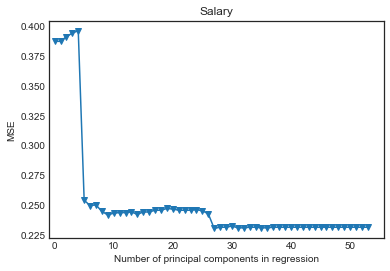

In [47]:
pca3 = PCA()
X_reduced_train = pca3.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)

mse = []
regr = LogisticRegression()

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train_2, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 54):
    score = abs(cross_val_score(regr, X_reduced_train[:,:i], y_train_2, cv=kf_10, scoring='neg_mean_squared_error')).mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1); #five is enough

In [48]:
mse.index(min(mse))

27

In [49]:
X_reduced_test = pca3.transform(scale(X_test))[:,:28]

# Train regression model on training data 
reg_log = LogisticRegression()
model = reg_log.fit(X_reduced_train[:,:28], y_train_2)

# Prediction with test data
y_pred_2 = reg_log.predict(X_reduced_test)
mean_squared_error(y_test_2, y_pred_2)

0.21884057971014492

In [50]:
compare_2 = pd.concat([pd.DataFrame(y_pred_2), y_test_2.reset_index(drop = True)], axis = 1)
compare_2.columns = ["pred_2", "test_2"]
correct = (compare_2["pred_2"] == compare_2["test_2"])
correct.value_counts()

True     1078
False     302
dtype: int64

In [51]:
print(classification_report(compare_2["test_2"], compare_2["pred_2"]))

             precision    recall  f1-score   support

          0       0.77      0.90      0.83       822
          1       0.80      0.61      0.69       558

avg / total       0.78      0.78      0.77      1380



In [24]:
len(X_train.columns)

53

In [21]:
X_test.columns

Index(['price_1', 'price_dif_1', 'sell_1', 'buy_1', 'volume_1', 'variation_1',
       'post_num_1', 'unique_id_1', 'click_1', 'like_1', 'dislike_1',
       'price_2', 'price_dif_2', 'sell_2', 'buy_2', 'volume_2', 'variation_2',
       'post_num_2', 'unique_id_2', 'click_2', 'like_2', 'dislike_2',
       'price_3', 'price_dif_3', 'sell_3', 'buy_3', 'volume_3', 'variation_3',
       'post_num_3', 'unique_id_3', 'click_3', 'like_3', 'dislike_3',
       'mkt_cap', 'kospi', 'kosdaq', 'trash', 'yesterday_closing_price',
       'is_maximum', 'is_minimum', 'price_volatility', 'price_trend',
       'average_price_volatility', 'sell_minus_buy_1', 'sell_minus_buy_2',
       'sell_minus_buy_3', 'is_price_gap_stable', 'price_gap_volatility',
       'is_like_higher', 'volume_trend', 'post_num_trend', 'unique_id_trend',
       'click_trend'],
      dtype='object')

Partial Least Square

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrat

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrat

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cross_decomposition\pls_.py:313: UserWarning: X scores are null at iteration 43
  warnings.warn('X scores are null at iteration %s' % k)
C:\Users\Administrat

(-1, 55.600000000000001)

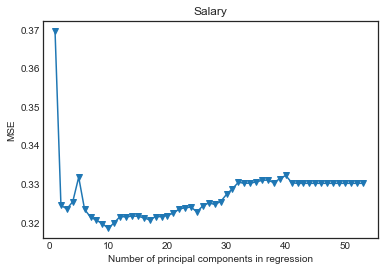

In [52]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)

mse = []

for i in np.arange(1, 54):
    pls = PLSRegression(n_components=i)
    score = cross_val_score(pls, scale(X_train), y_train_1, cv=kf_10, scoring='neg_mean_squared_error').mean()
    mse.append(-score)

plt.plot(np.arange(1, 54), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1) #four is enough

In [53]:
mse.index(min(mse))

9

In [54]:
pls = PLSRegression(n_components=10)
pls.fit(scale(X_train), y_train_1)
y_pred_pls = pls.predict(scale(X_test))

mean_squared_error(y_test_1, y_pred_pls)

0.26967004053136606

In [55]:
y_pls_df = pd.DataFrame(y_pred_pls)
compare_3 = pd.concat([y_pls_df, y_test_1.reset_index(drop = True)], axis = 1)
compare_3.columns = ["y_pred", "y_test_1"]

In [56]:
for index, row in compare_3.iterrows():
    if row["y_pred"] == 0:
        if row["y_test_1"] == 0:
            value = 1
        else:
            value = 0
    else:
        sign = row["y_pred"] * row["y_test_1"]
        if row["y_test_1"] == 0:
            value = 0
        elif sign > 0:
            value = 1 
        else:
            value = 0
    compare_3.set_value(index, "sign", value)

In [57]:
compare_3['sign'].value_counts()

1.0    893
0.0    487
Name: sign, dtype: int64